# Learning to Deep Learn using Python, Keras, TensorFlow and a GPU

_[Jonathon Hare, 21st Jan 2018](https://github.com/jonhare/DISCnetMachineLearningCourse)_

## Change History

- 20170308: Initial version
- 20170403: Update to use Keras 2 API
- 20180121: Update for LR
- 20180416: Update for DISCnet
- 20190408: Update for DISCnet/2 + Colab

## Acknowledgements
This part of the course is largely based on Jason Brownlee's ["Handwritten Digit Recognition using Convolutional Neural Networks in Python with Keras"](http://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/) tutorial. A number of changes have been made to ensure that it better fits our format, and I've added additional bits and exercises throughout. This version extends on one that Jon Hare ran for the VLC research group in October 2016 and a revised version for Ordnance Survey in April 2017.

## Introduction 
A popular demonstration of the capability of deep learning techniques is object recognition in image data. The "hello world" of object recognition for machine learning and deep learning is the MNIST dataset for handwritten digit recognition.

In this part of the tutorial you will discover how to develop a deep learning model to achieve near state of the art performance on the MNIST handwritten digit recognition task in Python using the Keras deep learning library.

Through this part of the tutorial you'll learn how to:

* How to load the MNIST dataset in Keras.
* How to develop and evaluate a baseline neural network model for the MNIST problem.
* How to switch the backends used by Keras and run your code on the GPU.
* How to implement and evaluate a simple Convolutional Neural Network for MNIST.
* How to implement a close to state-of-the-art deep learning model for MNIST.
* How to serialise and deserialise trained models.
* How to load your own image created outside of the MNIST dataset, and pass it through the network.
* How to visualise the filters learned by the network.
* How to implement networks with branching and merging.

## Prerequisites
To use this tutorial you'll use the Python 3 language with the `keras` deep learning library and the `tensorflow` backend. We'll also use the `scikit-learn` and `numpy` packages. For this lab we'll use a Jupyter notebook running in the cloud on [Google Colab](https://colab.research.google.com). Colab gives us free access to a virtual machine with GPU acceleration and all the prerequisite libraries pre-installed.

In [0]:
__Note:__ in Jupyter Notebooks, commands with an exclaimation mark (!) in front of them are shell commands, and will run just as if typed in a terminal (without the exclaimation mark).

If running locally you'll need access to a computer with the following installed:

- `Python` (> 3.6)
- `keras` (>= 2.0.0)
- `tensorflow` (>= 1.0.0)
- `NumPy` (>= 1.12.1)
- `SciPy` (>= 0.19.1)
- `scikit-learn` (>= 0.19.1)

If you've installed the base Anaconda python distribution, then running `conda install keras` will install both keras and tensorflow. You can make a start on this tutorial using you own machines, however you'll find that the code runs rather slowly. To run at more sensible speeds you need access to a machine with a powerful GPU (or GPUs).

## The MNIST Dataset
MNIST is a dataset developed by Yann LeCun, Corinna Cortes and Christopher Burges for evaluating machine learning models on the handwritten digit classification problem.

The dataset was constructed from a number of scanned document dataset available from the National Institute of Standards and Technology (NIST). This is where the name for the dataset comes from, as the Modified NIST or MNIST dataset.

Images of digits were taken from a variety of scanned documents, normalized in size and centred. This makes it an excellent dataset for evaluating models, allowing the developer to focus on the machine learning with very little data cleaning or preparation required.

Each image is a 28 by 28 pixel square (784 pixels total). A standard spit of the dataset is used to evaluate and compare models, where 60,000 images are used to train a model and a separate set of 10,000 images are used to test it.

It is a digit recognition task. As such there are 10 digits (0 to 9) or 10 classes to predict. Results are reported using prediction error, which is nothing more than the inverted classification accuracy.

Excellent results achieve a prediction error of less than 1%. State-of-the-art prediction error of approximately 0.2% can be achieved with large Convolutional Neural Networks. There is a listing of the state-of-the-art results and links to the relevant papers on the MNIST and other datasets on [Rodrigo Benenson’s webpage](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354).

## Loading the MNIST dataset in Keras

The Keras deep learning library provides a convenience method for loading the MNIST dataset.

The dataset is downloaded automatically the first time this function is called and is stored in your home directory in `~/.keras/datasets/mnist.pkl.gz` as a 15MB file.

This is very handy for developing and testing deep learning models.

To demonstrate how easy it is to load the MNIST dataset, we will first write a little script to download and visualize the first 4 images in the training dataset.

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


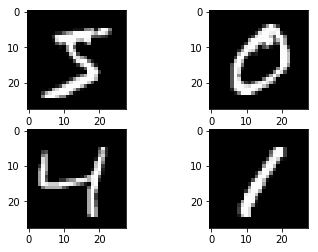

In [0]:
# Plot ad hoc mnist instances
from keras.datasets import mnist
import matplotlib
import matplotlib.pyplot as plt
# load (downloaded if needed) the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

You can see that downloading and loading the MNIST dataset is as easy as calling the `mnist.load_data()` function. Running the above example, you should see the image below.

![Examples from the MNIST dataset](https://raw.githubusercontent.com/jonhare/vlc-deep-learning-labs/master/mnist-samples.png "Examples from the MNIST dataset")

## Baseline Multi-Layer Perceptron Model

Keras is a general purpose neural network toolbox. Before we start to look at deep convolutional architectures, we can start with something much simpler - a basic multilayer perceptron. Because the MNIST images are relatively small, a fully connected MLP network will have relatively few weights to train; with bigger images, an MLP might not be practical due to the number of weights.

In this section we will create a simple multi-layer perceptron model with a single hidden layer that achieves an error rate of 1.74%. We will use this as a baseline for comparing more complex convolutional neural network models later.

Let's start off by importing the classes and functions we will need.

In [0]:
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils

When developing, it is always a good idea to initialize the random number generator to a constant to ensure that the results of your script are reproducible each time you run it.

In [0]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

Now we can load the MNIST dataset using the Keras helper function.

In [0]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

The training dataset is structured as a 3-dimensional array of instance, image width and image height. For a multi-layer perceptron model we must reduce the images down into a vector of pixels. In this case the 28×28 sized images will be 784 pixel input values.

We can do this transform easily using the `reshape()` function on the NumPy array. We can also reduce our memory requirements by forcing the precision of the pixel values to be 32 bit, the default precision used by Keras anyway.

In [0]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

The pixel values are gray scale between 0 and 255. It is almost always a good idea to perform some scaling of input values when using neural network models. Because the scale is well known and well behaved, we can very quickly normalize the pixel values to the range 0 and 1 by dividing each value by the maximum of 255.

In [0]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

Finally, the output variable is an integer from 0 to 9. This is a multi-class classification problem. As such, it is good practice to use a one hot encoding of the class values, transforming the vector of class integers into a binary matrix.

We can easily do this using the built-in `np_utils.to_categorical()` helper function in Keras.

In [0]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

We are now ready to create our simple neural network model. We will define our model in a function. This is handy if you want to extend the example later and try and get a better score.

In [0]:
# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
	model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

The model is a simple neural network with one hidden layer with the same number of neurons as there are inputs (784). A rectifier activation function is used for the neurons in the hidden layer.

A softmax activation function is used on the output layer to turn the outputs into probability-like values and allow one class of the 10 to be selected as the model's output prediction. Logarithmic loss is used as the loss function (called categorical_crossentropy in Keras) and the efficient ADAM gradient descent algorithm is used to learn the weights.

We can now fit and evaluate the model. The model is fit over 10 epochs with updates every 200 images. The test data is used as the validation dataset, allowing you to see the skill of the model as it trains. A verbose value of 2 is used to reduce the output to one line for each training epoch.

Finally, the test dataset is used to evaluate the model and a classification error rate is printed.

In [0]:
# build the model
model = baseline_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 4s - loss: 0.2783 - acc: 0.9210 - val_loss: 0.1412 - val_acc: 0.9575
Epoch 2/10
 - 1s - loss: 0.1116 - acc: 0.9676 - val_loss: 0.0925 - val_acc: 0.9701
Epoch 3/10
 - 1s - loss: 0.0718 - acc: 0.9799 - val_loss: 0.0784 - val_acc: 0.9770
Epoch 4/10
 - 1s - loss: 0.0505 - acc: 0.9857 - val_loss: 0.0741 - val_acc: 0.9768
Epoch 5/10
 - 1s - loss: 0.0375 - acc: 0.9892 - val_loss: 0.0671 - val_acc: 0.9792
Epoch 6/10
 - 1s - loss: 0.0271 - acc: 0.9928 - val_loss: 0.0635 - val_acc: 0.9804
Epoch 7/10
 - 1s - loss: 0.0211 - acc: 0.9944 - val_loss: 0.0617 - val_acc: 0.9815
Epoch 8/10
 - 1s - loss: 0.0139 - acc: 0.9968 - val_loss: 0.0624 - val_acc: 0.9802
Epoch 9/10
 - 1s - loss: 0.0108 - acc: 0.9978 - val_loss: 0.0595 - val_acc: 0.9807
Epoch 10/10
 - 1s - loss: 0.0080 - acc: 0.9984 - val_loss: 0.0583 - val_acc: 0.9813

Running the example might take a few minutes when run on a CPU (probably around 9s per epoch, but might be slower if you're sharing the machine with others). However, by default when using the Tensorflow backend the GPU will be used if it's available, and each epoch will be a lot faster:

In [0]:
Using TensorFlow backend.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
2018-01-21 14:47:42.029792: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2018-01-21 14:47:42.029818: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2018-01-21 14:47:42.618171: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-01-21 14:47:42.618900: I tensorflow/core/common_runtime/gpu/gpu_device.cc:887] Found device 0 with properties: 
name: GeForce GTX TITAN X
major: 5 minor: 2 memoryClockRate (GHz) 1.076
pciBusID 0000:02:00.0
Total memory: 11.92GiB
Free memory: 11.80GiB
2018-01-21 14:47:42.618923: I tensorflow/core/common_runtime/gpu/gpu_device.cc:908] DMA: 0 
2018-01-21 14:47:42.618934: I tensorflow/core/common_runtime/gpu/gpu_device.cc:918] 0:   Y 
2018-01-21 14:47:42.618949: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:02:00.0)
5s - loss: 0.2775 - acc: 0.9213 - val_loss: 0.1390 - val_acc: 0.9581
Epoch 2/10
1s - loss: 0.1097 - acc: 0.9685 - val_loss: 0.0911 - val_acc: 0.9729
Epoch 3/10
1s - loss: 0.0703 - acc: 0.9804 - val_loss: 0.0822 - val_acc: 0.9753
Epoch 4/10
1s - loss: 0.0495 - acc: 0.9859 - val_loss: 0.0750 - val_acc: 0.9778
Epoch 5/10
1s - loss: 0.0364 - acc: 0.9896 - val_loss: 0.0658 - val_acc: 0.9800
Epoch 6/10
1s - loss: 0.0265 - acc: 0.9932 - val_loss: 0.0643 - val_acc: 0.9803
Epoch 7/10
1s - loss: 0.0200 - acc: 0.9950 - val_loss: 0.0622 - val_acc: 0.9809
Epoch 8/10
1s - loss: 0.0139 - acc: 0.9970 - val_loss: 0.0626 - val_acc: 0.9810
Epoch 9/10
1s - loss: 0.0108 - acc: 0.9977 - val_loss: 0.0579 - val_acc: 0.9816
Epoch 10/10
1s - loss: 0.0081 - acc: 0.9984 - val_loss: 0.0566 - val_acc: 0.9821
Baseline Error: 1.79%

## Simple Convolutional Neural Network for MNIST

Now that we have seen how to load the MNIST dataset and train a simple multi-layer perceptron model on it, we can now start to develop a more sophisticated convolutional neural network or CNN model.

Keras provides a lot of capability for creating CNNs, and includes a large number of layer types and activation functions.

In this section we will create a simple CNN for MNIST that demonstrates how to use all of the aspects of a modern CNN implementation, including Convolutional layers, Pooling layers and Dropout layers.

The first step is to import the classes and functions needed.

In [0]:
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

Again, we always initialize the random number generator to a constant seed value for reproducibility of results.

In [0]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

Next we need to load the MNIST dataset and reshape it so that it is suitable for use training a CNN. In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions [width][height][pixels].

In the case of RGB, the third dimension, pixels, would be 3 for the red, green and blue components and it would be like having 3 image inputs for every colour image. In the case of MNIST where the pixel values are greyscale, the pixel dimension is set to 1.

In [0]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

As before, it is a good idea to normalize the pixel values to the range 0 and 1 and one-hot encode the output variables.

In [0]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

Next we define our neural network model.

Convolutional neural networks are more complex than standard multi-layer perceptrons, so we will start by using a simple structure to begin with that uses all of the elements for state of the art results. Below summarizes the network architecture.

1 The first hidden layer is a convolutional layer called a `Convolution2D`. The layer has 32 feature maps, which with the size of 5×5 and a rectifier activation function. This is the input layer, expecting images with the structure outline above [width][height][pixels].
2 Next we define a pooling layer that takes the max called `MaxPooling2D`. It is configured with a pool size of 2×2.
3 The next layer is a regularization layer using dropout called `Dropout`. It is configured to randomly exclude 20% of neurons in the layer in order to reduce overfitting.
4 Next is a layer that converts the 2D matrix data to a vector called `Flatten`. It allows the output to be processed by standard fully connected layers.
5 Next a fully connected layer with 128 neurons and rectifier activation function.
6 Finally, the output layer has 10 neurons for the 10 classes and a softmax activation function to output probability-like predictions for each class.

As before, the model is trained using logarithmic loss and the ADAM gradient descent algorithm.

In [0]:
def baseline_model():
	# create model
	model = Sequential()
	model.add(Convolution2D(32, (5, 5), padding='valid', input_shape=(28, 28, 1), activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dense(num_classes, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

We evaluate the model the same way as before with the multi-layer perceptron. The CNN is fit over 10 epochs with a batch size of 200.

In [0]:
# build the model
model = baseline_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 4s - loss: 0.2238 - acc: 0.9363 - val_loss: 0.0751 - val_acc: 0.9766
Epoch 2/10
 - 2s - loss: 0.0711 - acc: 0.9785 - val_loss: 0.0465 - val_acc: 0.9841
Epoch 3/10
 - 2s - loss: 0.0506 - acc: 0.9847 - val_loss: 0.0420 - val_acc: 0.9860
Epoch 4/10
 - 2s - loss: 0.0404 - acc: 0.9874 - val_loss: 0.0386 - val_acc: 0.9868
Epoch 5/10
 - 2s - loss: 0.0320 - acc: 0.9902 - val_loss: 0.0342 - val_acc: 0.9885
Epoch 6/10
 - 2s - loss: 0.0261 - acc: 0.9919 - val_loss: 0.0334 - val_acc: 0.9903
Epoch 7/10
 - 2s - loss: 0.0222 - acc: 0.9929 - val_loss: 0.0339 - val_acc: 0.9898
Epoch 8/10
 - 2s - loss: 0.0189 - acc: 0.9939 - val_loss: 0.0342 - val_acc: 0.9885
Epoch 9/10
 - 2s - loss: 0.0162 - acc: 0.9949 - val_loss: 0.0304 - val_acc: 0.9896
Epoch 10/10
 - 2s - loss: 0.0132 - acc: 0.9957 - val_loss: 0.0316 - val_acc: 0.9905
Base

Running the example, the accuracy on the training and validation test is printed each epoch and at the end of the classification error rate is printed.

Epochs may take a second or so on the GPU, although will take a fair bit longer on the CPU (perhaps ~46s per epoch). You can see that the network achieves an error rate of 1.06, which is better than the simple multi-layer perceptron model above.

In [0]:
Using TensorFlow backend.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
2018-01-21 14:49:59.159123: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2018-01-21 14:49:59.159149: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2018-01-21 14:49:59.412522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-01-21 14:49:59.413240: I tensorflow/core/common_runtime/gpu/gpu_device.cc:887] Found device 0 with properties: 
name: GeForce GTX TITAN X
major: 5 minor: 2 memoryClockRate (GHz) 1.076
pciBusID 0000:02:00.0
Total memory: 11.92GiB
Free memory: 11.80GiB
2018-01-21 14:49:59.413263: I tensorflow/core/common_runtime/gpu/gpu_device.cc:908] DMA: 0 
2018-01-21 14:49:59.413272: I tensorflow/core/common_runtime/gpu/gpu_device.cc:918] 0:   Y 
2018-01-21 14:49:59.413281: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:02:00.0)
4s - loss: 0.2258 - acc: 0.9347 - val_loss: 0.0788 - val_acc: 0.9755
Epoch 2/10
2s - loss: 0.0703 - acc: 0.9793 - val_loss: 0.0478 - val_acc: 0.9847
Epoch 3/10
2s - loss: 0.0506 - acc: 0.9843 - val_loss: 0.0426 - val_acc: 0.9865
Epoch 4/10
2s - loss: 0.0397 - acc: 0.9875 - val_loss: 0.0399 - val_acc: 0.9867
Epoch 5/10
2s - loss: 0.0323 - acc: 0.9899 - val_loss: 0.0346 - val_acc: 0.9876
Epoch 6/10
2s - loss: 0.0263 - acc: 0.9916 - val_loss: 0.0322 - val_acc: 0.9897
Epoch 7/10
2s - loss: 0.0211 - acc: 0.9936 - val_loss: 0.0357 - val_acc: 0.9884
Epoch 8/10
2s - loss: 0.0189 - acc: 0.9940 - val_loss: 0.0309 - val_acc: 0.9886
Epoch 9/10
2s - loss: 0.0168 - acc: 0.9946 - val_loss: 0.0302 - val_acc: 0.9896
Epoch 10/10
2s - loss: 0.0138 - acc: 0.9952 - val_loss: 0.0305 - val_acc: 0.9894
Baseline Error: 1.06%


## Larger Convolutional Neural Network for MNIST

Now that we have seen how to create a simple CNN, let’s take a look at a model capable of close to state of the art results.

We import classes and function then load and prepare the data the same as in the previous CNN example.

In [0]:
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
 
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
 
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
 
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

This time we define a large CNN architecture with additional convolutional, max pooling layers and fully connected layers. The network topology can be summarized as follows.

1 Convolutional layer with 30 feature maps of size 5×5.
2 Pooling layer taking the max over 2*2 patches.
3 Convolutional layer with 15 feature maps of size 3×3.
4 Pooling layer taking the max over 2*2 patches.
5 Dropout layer with a probability of 20%.
6 Flatten layer.
7 Fully connected layer with 128 neurons and rectifier activation.
8 Fully connected layer with 50 neurons and rectifier activation.
9 Output layer.

In [0]:
def larger_model():
	# create model
	model = Sequential()
	model.add(Convolution2D(30, (5, 5), padding='valid', input_shape=(28, 28, 1), activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Convolution2D(15, (3, 3), activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dense(50, activation='relu'))
	model.add(Dense(num_classes, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

Like the previous two experiments, the model is fit over 10 epochs with a batch size of 200.

In [0]:
# build the model
model = larger_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 2s - loss: 0.3808 - acc: 0.8837 - val_loss: 0.0818 - val_acc: 0.9750
Epoch 2/10
 - 2s - loss: 0.1024 - acc: 0.9686 - val_loss: 0.0597 - val_acc: 0.9788
Epoch 3/10
 - 2s - loss: 0.0730 - acc: 0.9778 - val_loss: 0.0396 - val_acc: 0.9878
Epoch 4/10
 - 2s - loss: 0.0594 - acc: 0.9818 - val_loss: 0.0352 - val_acc: 0.9883
Epoch 5/10
 - 2s - loss: 0.0498 - acc: 0.9842 - val_loss: 0.0355 - val_acc: 0.9889
Epoch 6/10
 - 2s - loss: 0.0448 - acc: 0.9859 - val_loss: 0.0290 - val_acc: 0.9910
Epoch 7/10
 - 2s - loss: 0.0380 - acc: 0.9882 - val_loss: 0.0329 - val_acc: 0.9889
Epoch 8/10
 - 2s - loss: 0.0365 - acc: 0.9884 - val_loss: 0.0279 - val_acc: 0.9901
Epoch 9/10
 - 2s - loss: 0.0307 - acc: 0.9905 - val_loss: 0.0230 - val_acc: 0.9928
Epoch 10/10
 - 2s - loss: 0.0294 - acc: 0.9900 - val_loss: 0.0271 - val_acc: 0.9910
Baseline Error: 0.90%


Running the example prints accuracy on the training and validation datasets each epoch and a final classification error rate.

The model takes about a couple of seconds to run per epoch on a GPU (CPU run times are around 60s/epoch). This slightly larger model achieves the respectable classification error rate of 0.84%.

In [0]:
Using TensorFlow backend.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
2018-01-21 14:51:56.002201: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2018-01-21 14:51:56.002228: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2018-01-21 14:51:56.256299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-01-21 14:51:56.257014: I tensorflow/core/common_runtime/gpu/gpu_device.cc:887] Found device 0 with properties: 
name: GeForce GTX TITAN X
major: 5 minor: 2 memoryClockRate (GHz) 1.076
pciBusID 0000:02:00.0
Total memory: 11.92GiB
Free memory: 11.80GiB
2018-01-21 14:51:56.257063: I tensorflow/core/common_runtime/gpu/gpu_device.cc:908] DMA: 0 
2018-01-21 14:51:56.257072: I tensorflow/core/common_runtime/gpu/gpu_device.cc:918] 0:   Y 
2018-01-21 14:51:56.257082: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:02:00.0)
3s - loss: 0.3846 - acc: 0.8830 - val_loss: 0.0805 - val_acc: 0.9754
Epoch 2/10
2s - loss: 0.1002 - acc: 0.9688 - val_loss: 0.0605 - val_acc: 0.9791
Epoch 3/10
2s - loss: 0.0721 - acc: 0.9780 - val_loss: 0.0393 - val_acc: 0.9877
Epoch 4/10
2s - loss: 0.0580 - acc: 0.9819 - val_loss: 0.0357 - val_acc: 0.9884
Epoch 5/10
2s - loss: 0.0487 - acc: 0.9844 - val_loss: 0.0343 - val_acc: 0.9898
Epoch 6/10
2s - loss: 0.0436 - acc: 0.9862 - val_loss: 0.0281 - val_acc: 0.9916
Epoch 7/10
2s - loss: 0.0378 - acc: 0.9882 - val_loss: 0.0328 - val_acc: 0.9886
Epoch 8/10
2s - loss: 0.0368 - acc: 0.9880 - val_loss: 0.0272 - val_acc: 0.9915
Epoch 9/10
2s - loss: 0.0306 - acc: 0.9902 - val_loss: 0.0236 - val_acc: 0.9931
Epoch 10/10
2s - loss: 0.0303 - acc: 0.9902 - val_loss: 0.0262 - val_acc: 0.9916
Baseline Error: 0.84%

## Saving models

Being able to train a model is fine, but in practice once we've trained the model we probably want to save the result so we can reuse it at a later time. Keras makes saving the model into an `HDF5` format file easy using `model.save(filepath)`. This will save the architecture of the model, the weights of the model, the training configuration (loss, optimizer) and the state of the optimizer, allowing to resume training exactly where you left off should you wish to continue training with more epochs.

> __Exercise:__ Can you modify the code for the previous CNN architecture to save the trained result into a file called `bettercnn.h5`?

## Reading models and propagating input

At this point, we know how to train a model and how to save the result. Lets assume we're in the business of building a real system for handwritten character recognition; we need to be able to read in a previously trained model and forward propagate an image from outside the MNIST dataset through it in order to generate a prediction. 

Firstly, let's download an image to use:

In [0]:
!wget https://github.com/ecs-vlc/ml_workshop_2019/raw/master/Keras/part1/1.PNG

--2019-05-19 13:03:51--  https://github.com/jonhare/DISCnetMachineLearningCourse/raw/master/Thursday/practical-part1/1.PNG
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jonhare/DISCnetMachineLearningCourse/master/Thursday/practical-part1/1.PNG [following]
--2019-05-19 13:03:52--  https://raw.githubusercontent.com/jonhare/DISCnetMachineLearningCourse/master/Thursday/practical-part1/1.PNG
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2448 (2.4K) [image/png]
Saving to: ‘1.PNG’

1.PNG               100%[===================>]   2.39K  --.-KB/s    in 0s      

2019-05-19 13:03:52 (60.6 MB/s) - ‘1.P

Now let's build some code load the model and apply it to the image:

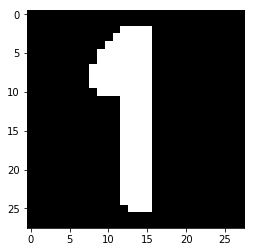

predicted digit: 1


In [30]:
import sys
from keras.models import load_model
from matplotlib import pyplot as plt
from PIL import Image
from imageio import imread

# load a model
#model = load_model('bettercnn.h5')

# load an image
image = imread('1.PNG').astype(float)

# normalise it in the same manner as we did for the training data
image = image / 255.0

#reshape
image = image.reshape(1,28,28,1)

# forward propagate and print index of most likely class 
# (for MNIST this corresponds one-to-one with the digit)
plt.imshow(imread('1.PNG'), cmap='gray')
plt.show()
print("predicted digit: "+str(model.predict_classes(image)[0]))

Running this should yield something like this:

In [0]:
Using TensorFlow backend.
2018-01-21 14:55:16.453161: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2018-01-21 14:55:16.453191: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2018-01-21 14:55:16.701871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-01-21 14:55:16.702581: I tensorflow/core/common_runtime/gpu/gpu_device.cc:887] Found device 0 with properties: 
name: GeForce GTX TITAN X
major: 5 minor: 2 memoryClockRate (GHz) 1.076
pciBusID 0000:02:00.0
Total memory: 11.92GiB
Free memory: 11.80GiB
2018-01-21 14:55:16.702605: I tensorflow/core/common_runtime/gpu/gpu_device.cc:908] DMA: 0 
2018-01-21 14:55:16.702613: I tensorflow/core/common_runtime/gpu/gpu_device.cc:918] 0:   Y 
2018-01-21 14:55:16.702623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:02:00.0)
1/1 [==============================] - 0s
predicted digit: 1

> __Exercise:__ Try with some other images and see what results you get. You can replace the 1 in the `wget` url above with anything between 0 and 9 to download some different digits, or create your own 24x24 pixel images.

> __Exercise:__ Rather than just outputting the most likely class, modify the code to print the weight distribution over the output layer using the `model.predict()` method instead of `model.predict_classes()`.

## Visualising the first layers filters and responses

In our previous convolutional network, the first layer was a Convolutional layer. Because this convolutional layer is applied directly to the greylevel input MNIST images the filters that are learned can themselves just be considered to be small (5x5 in this case) greylevel images. We can extract the weights of these filters directly from the trained network and visualise them using `matplotlib` like this:

In [0]:
from keras.models import load_model
from imageio import imread
import matplotlib
import matplotlib.pyplot as plt

# load a model
model = load_model('bettercnn.h5')

weights = model.layers[0].get_weights()[0]

# plot the first layer features
for i in xrange(0,30):
	plt.subplot(5,6,i+1)
	plt.imshow(weights[:,:,0,i], cmap=plt.get_cmap('gray'))

# show the plot
plt.show()

Note that the ordering of convolution filters in Tensorflow is [width][height][pixels][depth].

> __Exercise:__ Run the above code and see what the filters look like.

If we forward propagate an input through the network we can also visualise the response maps generated by the filters. The advantage of this kind of visualisation is that we can compute it at any layer, not just the first one. In order to do this in Keras, we must define a Keras function that will use the backend to propagate the given input through the network to the required point. The following code shows how this can be achieved to generate the response maps of the second convolutional layer of our network:

In [0]:
from keras.models import load_model
from keras import backend as K
from imageio import imread
import matplotlib
import matplotlib.pyplot as plt

# load a model
model = load_model('bettercnn.h5')

# load an image
image = imread("1.PNG").astype(float)

# normalise it in the same manner as we did for the training data
image = image / 255.0

# reshape
image = image.reshape(1,28,28,1)

# define a keras function to extract the 3rd layer response maps
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].output])
layer_output = get_3rd_layer_output([image])[0]

# plot the results
for i in xrange(0,15):
	plt.subplot(4,4,i+1)
	plt.imshow(layer_output[0,:,:,i], cmap=plt.get_cmap('gray'))

# show the plot
plt.show()

> __Exercise:__ Run the above code and see how the response maps differ for different input images.

A final way of visualising what the filters (at any depth) are learning is to find the input image that maximises the response of the filter. We can do this by starting with a random image and using gradient ascent to optimise the image to maximise the chosen filter. The following code snippet shows how this can be achieved, based on this article in the [Keras blog](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html):

In [0]:
from keras.models import load_model
from keras import backend as K
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# load a model
model = load_model('bettercnn.h5')

input_img = model.input

step=1

# we're interested in maximising outputs of the 3rd layer:
layer_output = model.layers[3].output

for i in xrange(0,15):
	# build a loss function that maximizes the activation
	# of the nth filter of the layer considered
	loss = K.mean(layer_output[:, :, :, i])

	# compute the gradient of the input picture wrt this loss
	grads = K.gradients(loss, input_img)[0]

	# normalization trick: we normalize the gradient
	grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

	# this function returns the loss and grads given the input picture
	iterate = K.function([input_img], [loss, grads])

	# we start from a gray image with some noise
	input_img_data = np.random.random((1, 28, 28, 1)) * 0.07 + 0.5
	
	# run gradient ascent for 50 steps
	for j in range(50):
		loss_value, grads_value = iterate([input_img_data])
		input_img_data += grads_value * step

	# plot the results
	plt.subplot(4,4,i+1)
	plt.imshow(input_img_data[0,:,:,0], cmap=plt.get_cmap('gray'))

# show the plot
plt.show()

> __Exercise:__ Run the above code to see what the filters respond to.

## More advanced network topologies

Recent network models, such as the deep residual network (ResNet) and GoogLeNet architectures, do not follow a straight path from input to output. Instead, these models incorporate branches and merges to create a computation graph. Branching and merging is easy to implement in Keras as show in the following code snippet:

In [0]:
from keras.layers import Input
from keras.layers.merge import add
from keras.models import Model

def branch_model():
	model = Sequential()

	x = Input(shape=(28, 28, 1))
	left = Convolution2D(16, (1, 1), padding='same')(x)
	right = Convolution2D(16, (5, 5), padding='same', activation='relu')(x)
	y = add([left, right])
	block = Model(inputs=x, outputs=y)

	model.add(block)
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dense(num_classes, activation='softmax'))
	
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

This defines a variant of our initial simple CNN model in which the input is split into two paths and then merged again; the left hand path consists of a 1x1 convolution layer, whilst the right-hand path has a 5x5 convolutional layer. The 1x1 convolutions will have the effect of increasing the number of bands in the input from 1 to 16 (with each band a [potentially different] scalar multiple of the input]. In this case the left and right branches are merged by summing them together (element-wise, layer by layer).

> __Exercise:__ Try running the above network model on the MNIST data. What accuracy do you achieve?

## Going further

None of the network topology we have experimented with thus far are optimised. Nor are they reproductions of network topologies from recent papers.

> __Exercise:__ There is a lot of opportunity for you to tune and improve upon these models. What is the best error rate score you can achieve?